# LangSmith and Evaluation Overview with AI Makerspace

Today we'll be looking at an amazing tool:

[LangSmith](https://docs.smith.langchain.com/)!

This tool will help us monitor, test, debug, and evaluate our LangChain applications - and more!

We'll also be looking at a few Advanced Retrieval techniques along the way - and evaluate it using LangSmith!

✋BREAKOUT ROOM #2:
- Task 1: Dependencies and OpenAI API Key
- Task 2: LangGraph RAG
- Task 3: Setting Up LangSmith
- Task 4: Examining the Trace in LangSmith!
- Task 5: Create Testing Dataset
- Task 6: Evaluation

## Task 1: Dependencies and OpenAI API Key

We'll be using OpenAI's suite of models today to help us generate and embed our documents for our simple RAG system that leverages Loand Complaint data.

In [ ]:
import os
import getpass
import openai

openai.api_key = ""


#### Asyncio Bug Handling

In [6]:
import nest_asyncio
nest_asyncio.apply()

## Task #2: Create a Simple RAG Application Using LangGraph

Let's remake our LangGraph RAG pipeline from the first notebook!

## LangGraph Powered RAG

First and foremost, LangChain provides a convenient way to store our chunks and their embeddings.

It's called a `VectorStore`!

We'll be using QDrant as our `VectorStore` today. You can read more about it [here](https://qdrant.tech/documentation/).

Think of a `VectorStore` as a smart way to house your chunks and their associated embedding vectors. The implementation of the `VectorStore` also allows for smarter and more efficient search of our embedding vectors - as the method we used above would not scale well as we got into the millions of chunks.

Otherwise, the process remains relatively similar under the hood!

### Data Collection

We'll be leveraging the `DirectoryLoader` to load our PDFs!

In [7]:
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import PyMuPDFLoader

directory_loader = DirectoryLoader("data", glob="**/*.pdf", loader_cls=PyMuPDFLoader)

jr_document = directory_loader.load()

jr_document[5].page_content

'case of any especially tenacious “demon,” he could without much\ndifficulty be merged into a Christian saint or devil. There was no\norganized priesthood to be overcome, the primitive religious\nobservances consisting almost entirely of occasional orgies presided\nover by an old woman, who filled the priestly offices of interpreter for\nthe unseen powers and chief eater at the sacrificial feast. With their\nunflagging zeal, their organization, their elaborate forms and\nceremonies, the missionaries were enabled to win the confidence of\nthe natives, especially as the greater part of them learned the local\nlanguage and identified their lives with the communities under their\ncare. Accordingly, the people took kindly to their new teachers and\nrulers, so that in less than a generation Spanish authority was\ngenerally recognized in the settled portions of the Philippines, and in\nthe succeeding years the missionaries gradually extended this area\nby forming settlements from among the wi

### Chunking Our Documents

Let's do the same process as we did before with our `RecursiveCharacterTextSplitter` - but this time we'll use ~200 tokens as our max chunk size!

In [8]:
import tiktoken
from langchain.text_splitter import RecursiveCharacterTextSplitter

def tiktoken_len(text):
    tokens = tiktoken.encoding_for_model("gpt-4o").encode(
        text,
    )
    return len(tokens)

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 750,
    chunk_overlap = 0,
    length_function = tiktoken_len,
)
jose_rizal_chunks = text_splitter.split_documents(jr_document)

In [9]:
len(jose_rizal_chunks)

812

Let's verify the process worked as intended by checking our max document length.

In [10]:
max_chunk_length = 0

for chunk in jose_rizal_chunks:
  max_chunk_length = max(max_chunk_length, tiktoken_len(chunk.page_content))

print(max_chunk_length)

722


Perfect! Now we can carry on to creating and storing our embeddings.

### Embeddings and Vector Storage

We'll use the `text-embedding-3-small` embedding model again - and `Qdrant` to store all our embedding vectors for easy retrieval later!

In [ ]:
from langchain_community.vectorstores import Qdrant
from langchain_openai.embeddings import OpenAIEmbeddings

import os
os.environ["OPENAI_API_KEY"] = ""


embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")

qdrant_vectorstore = Qdrant.from_documents(
    documents=jose_rizal_chunks,
    embedding=embedding_model,
    location=":memory:"
)

Now let's set up our retriever, just as we saw before, but this time using LangChain's simple `as_retriever()` method!

In [12]:
qdrant_retriever = qdrant_vectorstore.as_retriever()

#### Back to the Flow

We're ready to move to the next step!

### Setting up our RAG

We'll use the same LangGraph pipeline we created in the first notebook. 

Let's think through each part:

1. First we need to retrieve context
2. We need to pipe that context to our model
3. We need to parse that output

Let's start by setting up our prompt again, just so it's fresh in our minds!

Complete the prompt so that your RAG application answers queries based on the context provided, but *does not* answer queries if the context is unrelated to the query.

In [32]:
from langchain_core.prompts import ChatPromptTemplate

HUMAN_TEMPLATE = """
#CONTEXT:
{context}

QUERY:
{query}

Use the provide context to answer the provided user query. Only use the provided context to answer the query. If you do not know the answer, or it's not contained in the provided context respond with "I don't know"


""" 
chat_prompt = ChatPromptTemplate.from_messages([
    ("human", HUMAN_TEMPLATE)
])

We'll set our Generator - `gpt-4.1-nano` in this case - below!

In [33]:
from langchain_openai import ChatOpenAI

openai_chat_model = ChatOpenAI(model="gpt-4o-mini")

#### Our RAG Application

Let's spin up the graph.

In [34]:
from langgraph.graph import START, StateGraph
from typing_extensions import TypedDict
from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser

class State(TypedDict):
  question: str
  context: list[Document]
  response: str

def retrieve(state: State) -> State:
  retrieved_docs = qdrant_retriever.invoke(state["question"])
  return {"context" : retrieved_docs}

def generate(state: State) -> State:
  generator_chain = chat_prompt | openai_chat_model | StrOutputParser()
  response = generator_chain.invoke({"query" : state["question"], "context" : state["context"]})
  return {"response" : response}

graph_builder = StateGraph(State)
graph_builder = graph_builder.add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
rag_graph = graph_builder.compile()

Let's get a visual understanding of our chain!

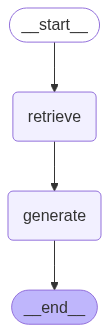

In [35]:
rag_graph

Let's test our chain out!

In [36]:
response = rag_graph.invoke({"question" : "When did the Philippines gain independence?"})
response["response"]

"I don't know."

<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

### 🎯 Breakout Room - Group Discussion: 

Why did the model answer the question even when its not related to writings of Dr. Jose Rizal?

How can you improve the prompt to respond only within the context?  
</div>

<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

### Observations :

* The default prompt doesn’t have any instructions or guardrails telling the model to ignore prior training knowledge or to only answer using the retrieved context. So the model fell back on its pretrained knowledge of Noli Me Tangere (which includes Capitan Tiago) and answered anyway, even if the retrieved context didn’t strongly back it up.
* You need to explicitly tell the model to only use the given context, avoid guessing or relying on external knowledge, and admit if the answer isn’t found
</span>


## Task 3: Setting Up LangSmith (Extra! Extra!)

Now that we have a chain - we're ready to get started with LangSmith!

Create a Langsmith account here(https://smith.langchain.com/) and Setup your API key.

We're going to go ahead and use the following `env` variables to get our notebook set up to start reporting.

If all you needed was simple monitoring - this is all you would need to do!

In [18]:
from uuid import uuid4
import os
from getpass import getpass

PROJECT_NAME = f"PSI AI Eng - DAY_3 - {uuid4().hex[0:8]}"

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = PROJECT_NAME

### LangSmith API

In order to use LangSmith - you will need an API key. You can sign up for a free account on [LangSmith's homepage!](https://www.langchain.com/langsmith)

Once you have created your account, Take the navigation option for `Settings` then `API Keys` to create an API key.

In [ ]:
f\LangChainTracer

os.environ["LANGSMITH_API_KEY"] = ""

tracer = LangChainTracer()  
tracer.project_name = PROJECT_NAME

Let's test our our first generation!

In [20]:
result = rag_graph.invoke(
    {"question": "Who is Capitan Tiago?"},
    config={"tags": ["Demo Run"], "callbacks": [tracer]}
)

print("\nResponse:\n", result['response'])
print("\nTracing Project name:", tracer.project_name)



Response:
 Capitan Tiago, whose full name is Don Santiago de los Santos, is a character in José Rizal's novel "The Social Cancer." He is depicted as a low-statured man with a corpulent figure and a full face, giving him a younger appearance than his actual age, which is believed to be between thirty and thirty-five. Capitan Tiago is characterized by his sanctified look, black hair, small eyes without a Chinese slant, and a slender nose. He is described as one of the richest landlords in the Binondo area and a notable planter because of his estates in Pampanga.

He is considered to be hospitable and well-regarded in his community, known for hosting lavish dinners that attract various socialites and members of society. However, there is a contrast in the way he is viewed; while he enjoys the favor of debtors who treat him well, they often mock him behind his back. Capitan Tiago embodies the complexities of social standing and the perceptions of power in the colonial Philippines context.

## Task 4: Examining the Trace in LangSmith!

Head on over to your LangSmith web UI to check out how the trace looks in LangSmith!

<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

#### 🏗️ Activity #1:

Include a screenshot of your trace and explain what it means.
</div>

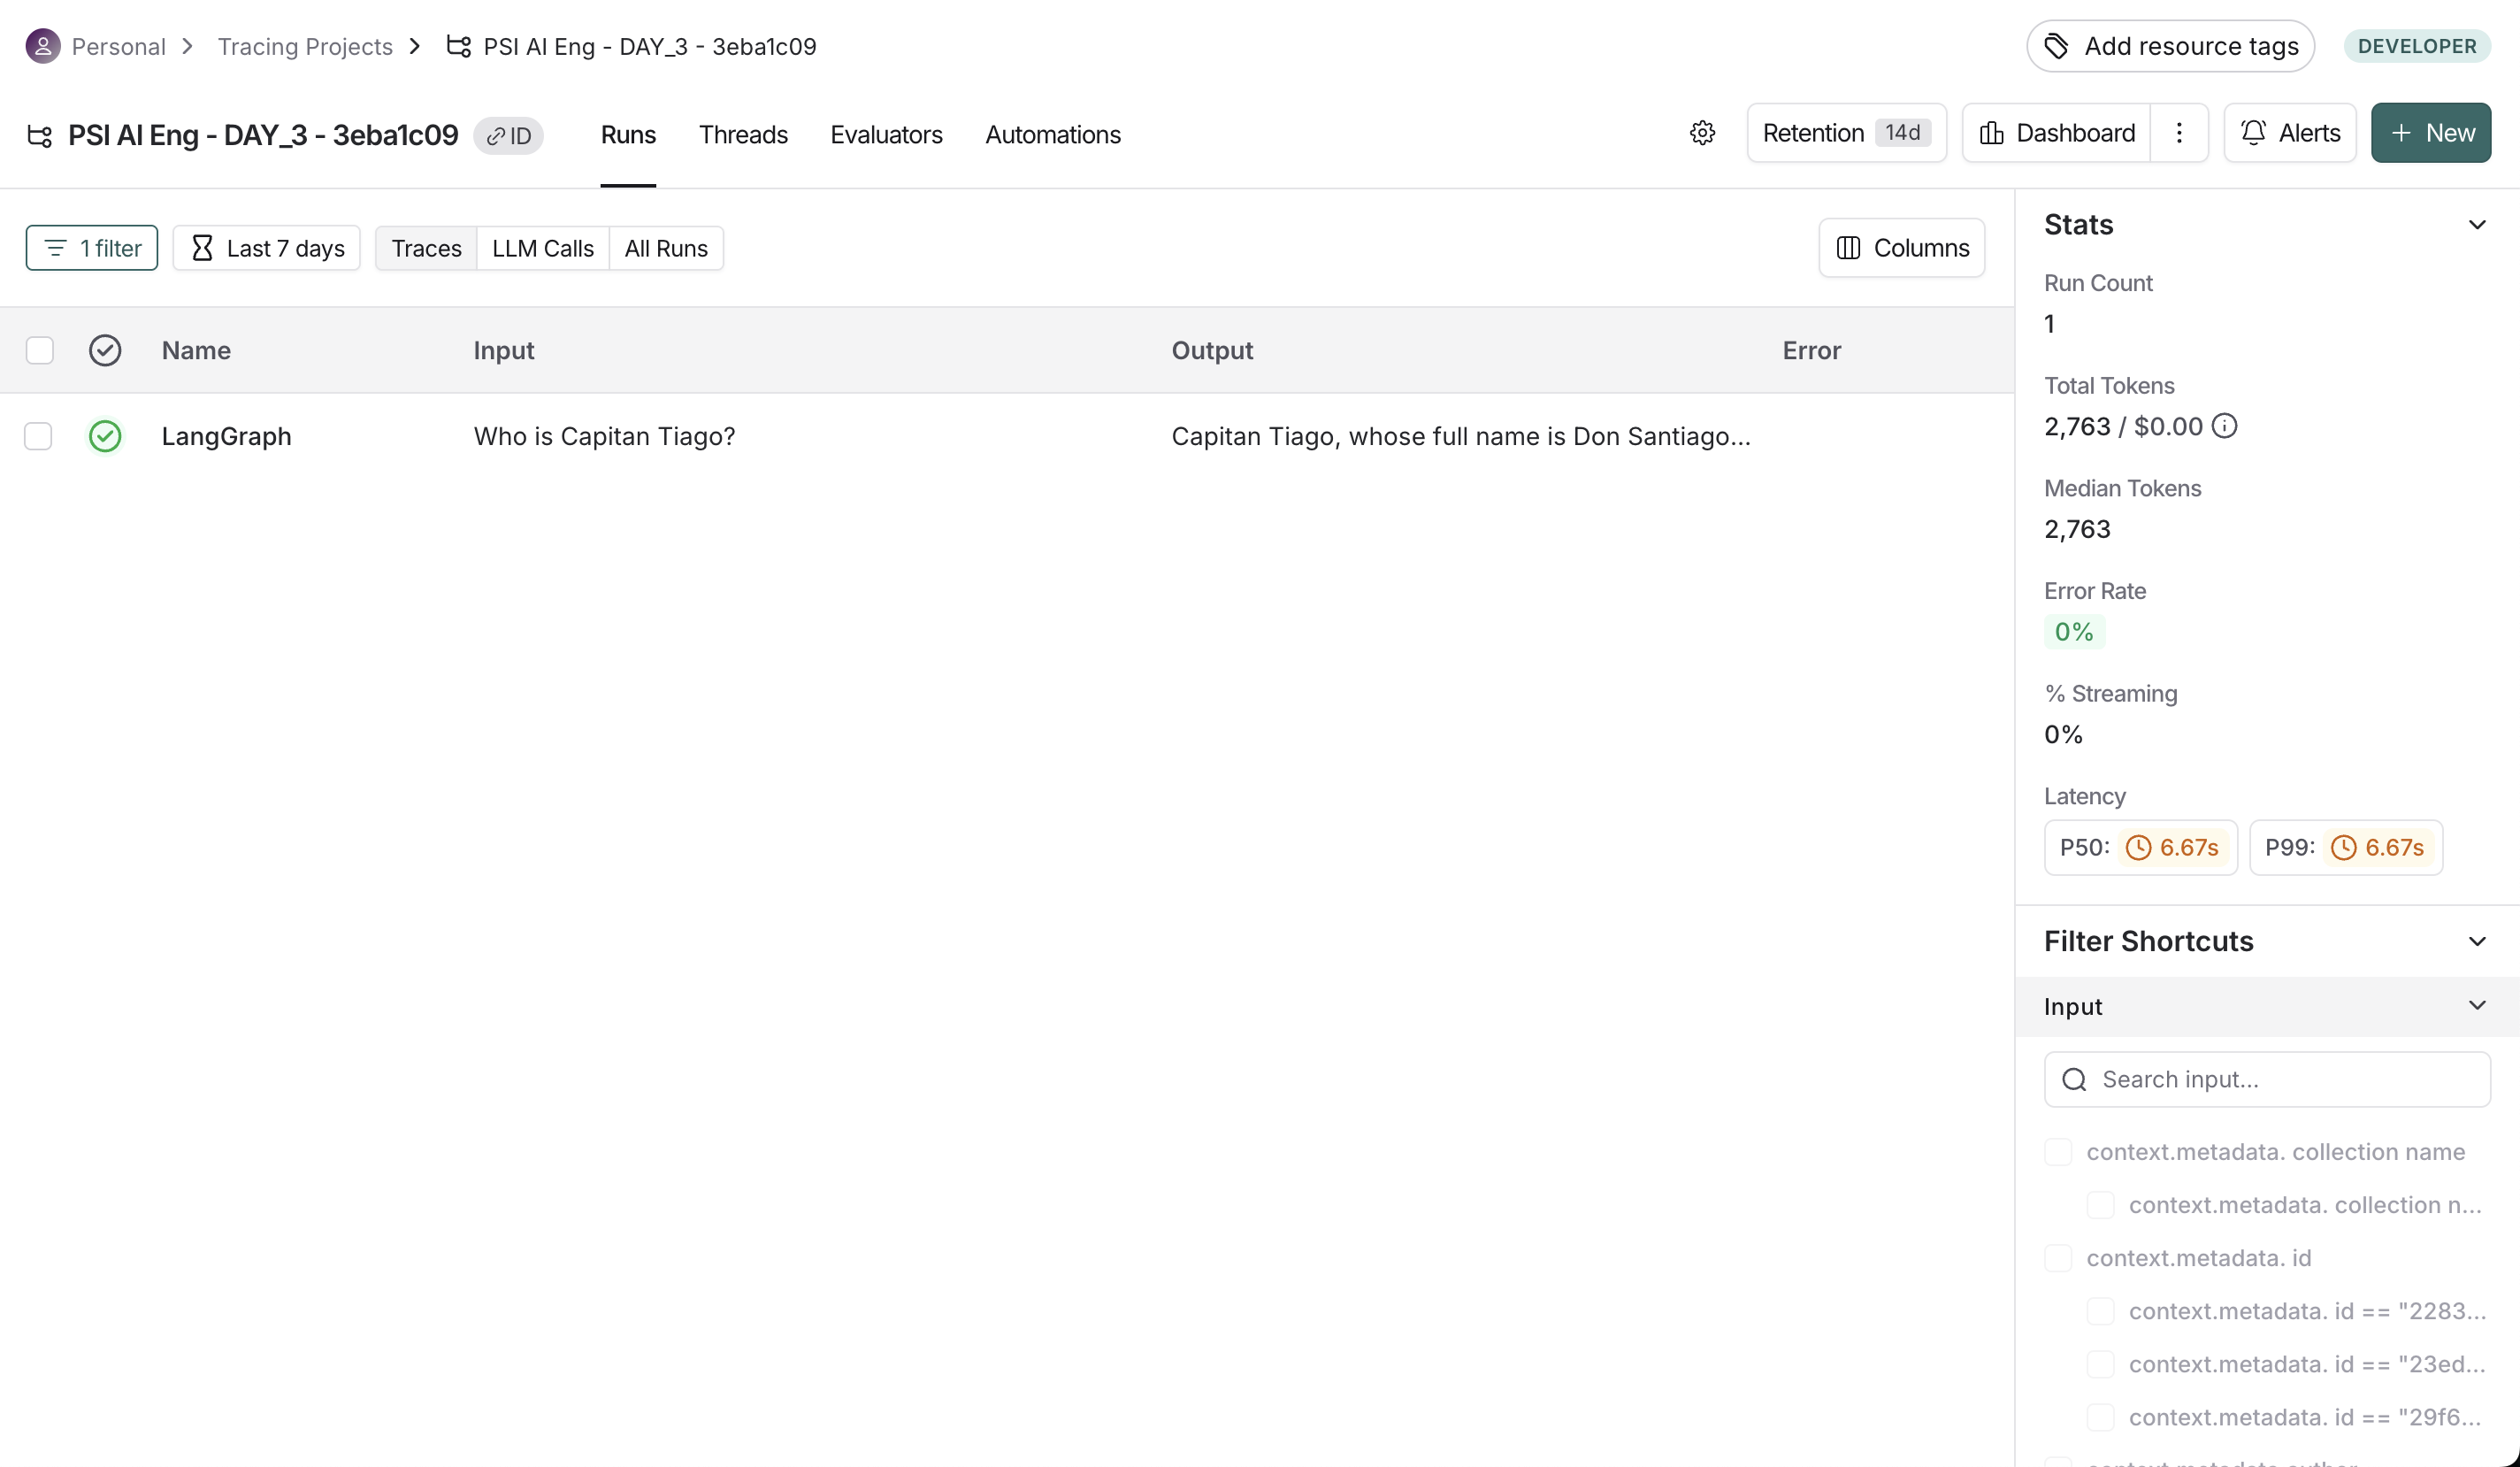

In [1]:
from IPython.display import Image, display

display(Image(filename="screenshot.png"))

<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

### Observations :

* The model answered the question without any errors and sticked to the retrieved context.
* The model knew the answer on its own and responded even if the context didn’t contain it.

</span>
